In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# install the requirements
!pip install -r pip_requirements.txt

In [3]:
import pandas as pd
from collections import Counter
import ast
import matplotlib.pyplot as plt
from src.scripts.cmu_scripts import *


# Cleaning the CMU dataset
First of all, we need to pre-process the CMU dataset in order to have cleaned data to process.

### Load the data

In [4]:
# We begin by loading the data
DATAPATH = "src/data/"
movies_df = load_tsv(DATAPATH + "movie.metadata.tsv")
characters_df = load_tsv(DATAPATH + "character.metadata.tsv")

### Filter and name

We see that the Dataframes have a lot of columns which are not always useful. In addition, they do not have a name. So let's begin by giving a name to those columns and filtering those we do not need.

In [5]:
# We name the columns and pick which ones we want
movies_df, characters_df = name_and_filter_columns(movies_df, characters_df)

It is really important to track the NaN values in the dataset, so let's print the info we have on each column.

Total entries: 81741

Wikipedia movie ID       0
Freebase movie ID        0
Movie name               0
Movie release date    6902
Movie countries          0
Movie genres             0
dtype: int64


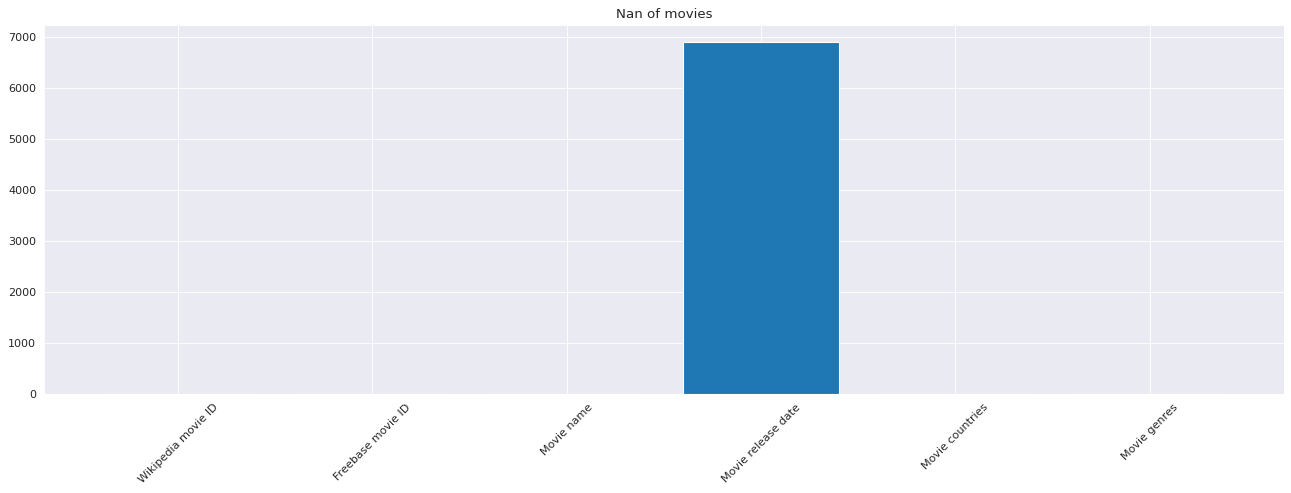

________________________
Total entries: 450669

Freebase movie ID                  0
Character name                257875
Actor date of birth           106145
Actor gender                   45609
Actor name                      1228
Actor age at movie release    158113
Freebase character ID         257865
Freebase actor ID                815
dtype: int64


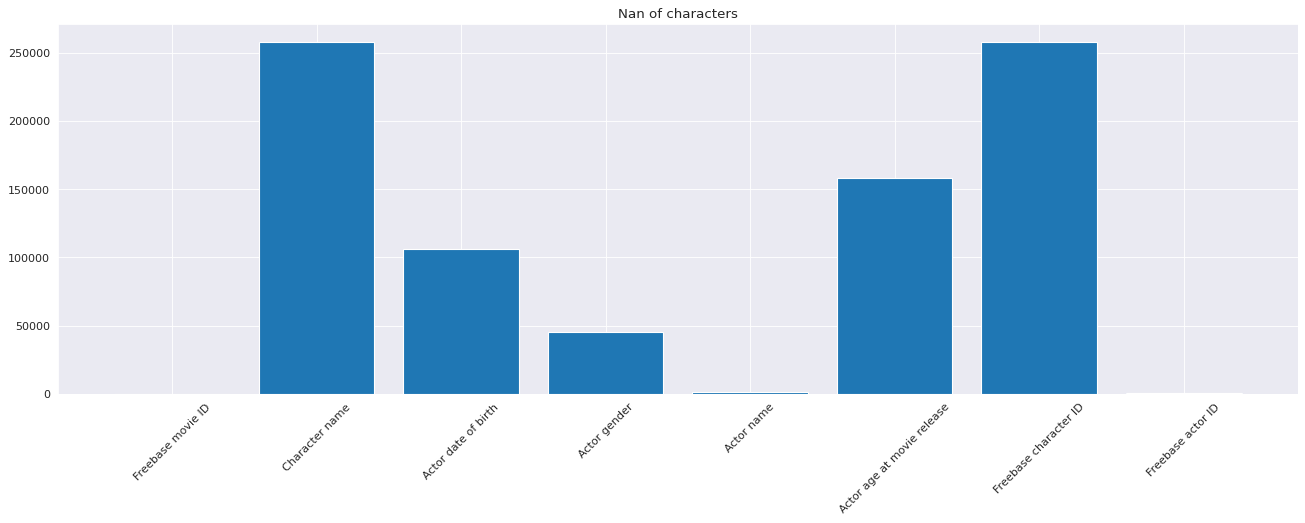

In [6]:
# We print some info about NaNs
plot_nan_values(movies_df, "Nan of movies")
plt.show()
print("________________________")
plot_nan_values(characters_df, "Nan of characters")
plt.show()

Let's see also how is the data.

In [7]:
movies_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,"{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,"{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,"{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,"{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [8]:
characters_df.head()

,Freebase movie ID,Character name,Actor date of birth,Actor gender,Actor name,Actor age at movie release,Freebase character ID,Freebase actor ID
0,/m/03vyhn,Akooshay,1958-08-26,F,Wanda De Jesus,42.0,/m/0bgcj3x,/m/03wcfv7
1,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,Natasha Henstridge,27.0,/m/0bgchn4,/m/0346l4
2,/m/03vyhn,Desolation Williams,1969-06-15,M,Ice Cube,32.0,/m/0bgchn_,/m/01vw26l
3,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,Jason Statham,33.0,/m/0bgchnq,/m/034hyc
4,/m/03vyhn,Bashira Kincaid,1977-09-25,F,Clea DuVall,23.0,/m/0bgchp9,/m/01y9xg


#### Analyze
We see that the data is OK, but there are some problems. Firstly, the Freebase IDs are obsolete, so we cannot retrieve any information from that. However, it can link the two tables and serve as an indices. We will therefore keep some. Secondly, the dates are awful. Sometimes in the format 'YYYY-MM-DD' sometimes 'YYYY' or NaN and always in string. Third, the actor age are float, but we can consider it as int. Finally, the 'Movie countries' and 'Movie Genres' columns are stored as a "string dict" with a Freebase ID as an index. It cannot be used as this.

### Reformat and type fixing

We saw that the 'Movie countries' and 'Movie genres' have a strange format. It includes a Freebase id and its real value. Let's fix this by converting the string dict to a list of the real values.

In [9]:
#We transform the movie genres and countries from a string dict to a list
movies_df = refactor_movie_genres_countries(movies_df)
movies_df[['Movie countries', 'Movie genres']].head()

,Movie countries,Movie genres
0,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,[Norway],"[Crime Fiction, Drama]"
3,[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,[Germany],[Drama]


We also see that the dates do not all have the same format and have absurd values (like year 1000). Let's change this by taking only the year of the date,casting it to `int` and change all absurd values by NaN. (N.B. this may be tricky since these columns contains NaN values). 

In [10]:
# We refactor the release date (take only the year and cast to int)
movies_df = refactor_movie_release_date(movies_df)
movies_df['Movie release date'].head()

0    2001
1    2000
2    1988
3    1987
4    1983
Name: Movie release date, dtype: Int64

In [11]:
# We do the same with the date of birth
characters_df = refactor_actor_dob(characters_df)
characters_df['Actor date of birth'].head()

0    1958
1    1974
2    1969
3    1967
4    1977
Name: Actor date of birth, dtype: Int64

Then, we see that the 'Actor age at movie release' column is in float, while it logically must contain only integer values. We can just cast it.

In [12]:
print(type(characters_df['Actor age at movie release'][7]))

<class 'numpy.float64'>


In [13]:
# We cast actor age to int
characters_df['Actor age at movie release'] = characters_df['Actor age at movie release'].astype('Int64')
characters_df.head()

,Freebase movie ID,Character name,Actor date of birth,Actor gender,Actor name,Actor age at movie release,Freebase character ID,Freebase actor ID
0,/m/03vyhn,Akooshay,1958,F,Wanda De Jesus,42,/m/0bgcj3x,/m/03wcfv7
1,/m/03vyhn,Lieutenant Melanie Ballard,1974,F,Natasha Henstridge,27,/m/0bgchn4,/m/0346l4
2,/m/03vyhn,Desolation Williams,1969,M,Ice Cube,32,/m/0bgchn_,/m/01vw26l
3,/m/03vyhn,Sgt Jericho Butler,1967,M,Jason Statham,33,/m/0bgchnq,/m/034hyc
4,/m/03vyhn,Bashira Kincaid,1977,F,Clea DuVall,23,/m/0bgchp9,/m/01y9xg


We have seen that there is some countries in the dataset that no longer exist (West germany , USSR for example). We have created a dictionary defined in 'clean_country.py' to clean these countries.

In [14]:
# clean the countries
from src.utils.clean_country import country_mapping
movies_df['Movie countries'] = movies_df['Movie countries'].apply(lambda x: [country_mapping.get(elem) for elem in x])
# remove duplicate in list (like west and est germany)
movies_df['Movie countries'] = movies_df['Movie countries'].apply(lambda x: list(set(x)))

### Joining the Dataframes
Now that we have corrected the values, we can join the two Dataframes in order to have all information on one big Dataframe.

In [15]:
# We join the two dataframes
joined_df = characters_df.join(movies_df.set_index('Freebase movie ID'), on='Freebase movie ID', how='left')

In [16]:
joined_df.head()

,Freebase movie ID,Character name,Actor date of birth,Actor gender,Actor name,Actor age at movie release,Freebase character ID,Freebase actor ID,Wikipedia movie ID,Movie name,Movie release date,Movie countries,Movie genres
0,/m/03vyhn,Akooshay,1958,F,Wanda De Jesus,42,/m/0bgcj3x,/m/03wcfv7,975900,Ghosts of Mars,2001,[United States],"[Thriller, Science Fiction, Horror, Adventure,..."
1,/m/03vyhn,Lieutenant Melanie Ballard,1974,F,Natasha Henstridge,27,/m/0bgchn4,/m/0346l4,975900,Ghosts of Mars,2001,[United States],"[Thriller, Science Fiction, Horror, Adventure,..."
2,/m/03vyhn,Desolation Williams,1969,M,Ice Cube,32,/m/0bgchn_,/m/01vw26l,975900,Ghosts of Mars,2001,[United States],"[Thriller, Science Fiction, Horror, Adventure,..."
3,/m/03vyhn,Sgt Jericho Butler,1967,M,Jason Statham,33,/m/0bgchnq,/m/034hyc,975900,Ghosts of Mars,2001,[United States],"[Thriller, Science Fiction, Horror, Adventure,..."
4,/m/03vyhn,Bashira Kincaid,1977,F,Clea DuVall,23,/m/0bgchp9,/m/01y9xg,975900,Ghosts of Mars,2001,[United States],"[Thriller, Science Fiction, Horror, Adventure,..."


Total entries: 450669

Freebase movie ID                  0
Character name                257875
Actor date of birth           106170
Actor gender                   45609
Actor name                      1228
Actor age at movie release    158113
Freebase character ID         257865
Freebase actor ID                815
Wikipedia movie ID                 0
Movie name                         0
Movie release date             10010
Movie countries                    0
Movie genres                       0
dtype: int64


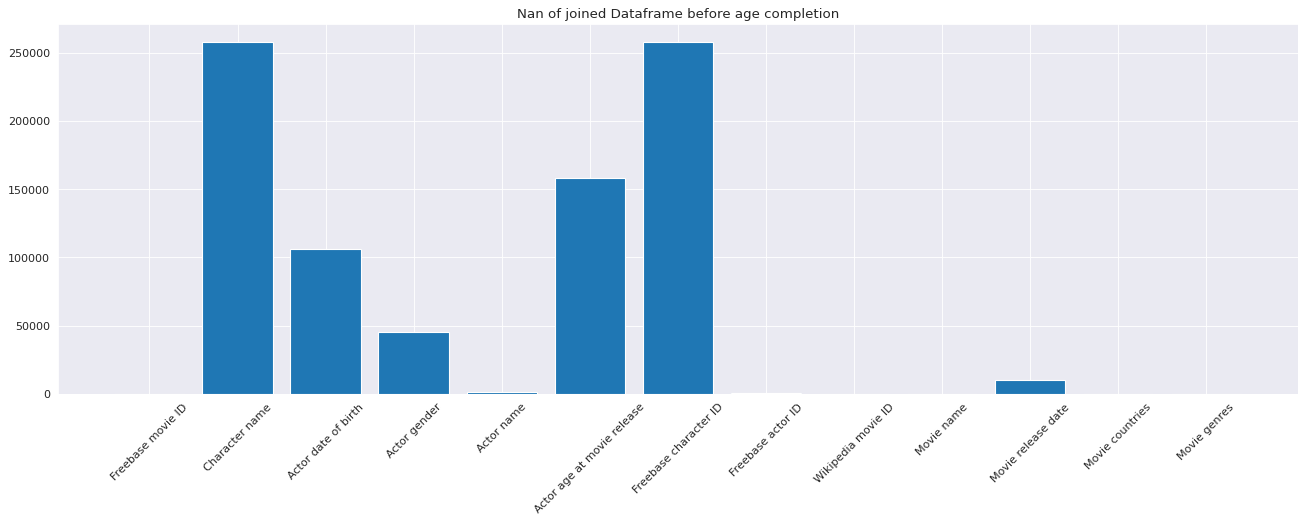

In [17]:
plot_nan_values(joined_df, "Nan of joined Dataframe before age completion")
plt.show()

### Age completion

A lot of ages at movie release are still missing. Since we know the date of birth and the movie release date, we can easily deduce the actor age at movie release. Let's do that.
As we do not need the date of birth and the movie release date, we can just remove them.

Total entries: 450669

Freebase movie ID                  0
Character name                257875
Actor date of birth           106170
Actor gender                   45609
Actor name                      1228
Actor age at movie release    115273
Freebase character ID         257865
Freebase actor ID                815
Wikipedia movie ID                 0
Movie name                         0
Movie release date             10010
Movie countries                    0
Movie genres                       0
dtype: int64


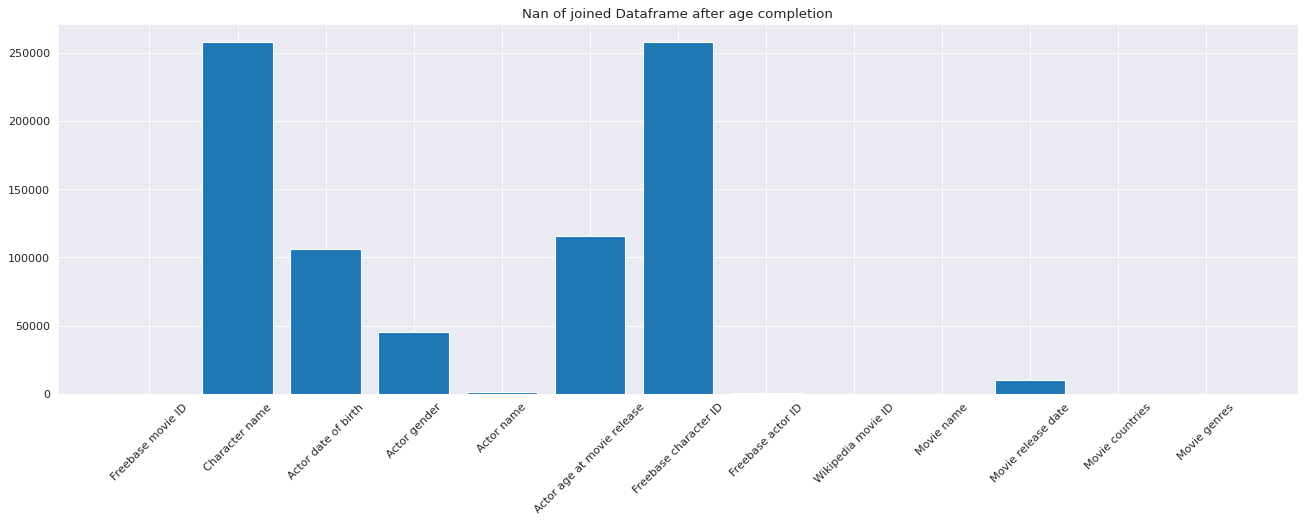

In [18]:
preprocessed_df = complete_age(joined_df)
plot_nan_values(joined_df, "Nan of joined Dataframe after age completion")

(N.B. If we still need more data, we can complete the age of the actors by looking on another database like Wikidata)

### Storing
We need now to store the DataFrame. A pickle is a great choice since it is fast.

In [19]:
preprocessed_df.to_pickle("./src/data/metadata_cmu.pkl")

# Q1. What are the possible career paths, steps and possible trajectories ?
An important part of our project is to link actors with their career path. We defined the career path as a chronological list the personas of all characters he played.
We can split this task in two steps:
- link characters to their personas
- link actor to their personas using the fact that the metadata contains character names.

## Link characters to their personas
To do this, we extracted characters and their personas from the movies summaries. We did this using the ``gpt4o mini`` model, prompting it to extract characters and their personas of each summary. We currently only computed this for the first 9000 summaries of the ``plot_summaries.txt``, but the rest can be computed in 4 days (not doable faster than 10000 documents a day due to API limitations).

In [71]:
pd.read_pickle('src/data/processed_data0-9000.pkl')

,name,persona,wikipedia_id
0,Shlykov,[the warrior],23890098
1,Lyosha,"[the rebel, the lover]",23890098
0,Katniss Everdeen,"[the warrior, the caregiver, the rebel]",31186339
1,Peeta Mellark,"[the lover, the caregiver, the seducer]",31186339
2,Primrose Everdeen,"[the child, the orphan]",31186339
...,...,...,...
4,The Chief of Police,"[the ruler, the mentor]",6183117
0,Noah Arkwright,"[the rebel, the creator, the lover]",10572926
1,Kirstin,"[the caregiver, the mentor]",10572926
2,Ray,"[the joker, the caregiver]",10572926


then we can link the personas with the cator who played them using the character name and the wikipedia movie id.

In [72]:
career_paths = pd.read_pickle('src/data/careers_paths.pkl')
career_paths.head()

,personas_list,actor_age_during_movies,wikipedia_movies_id,freebase_actor_id
actor_name,,,,
50 Cent,"[[the orphan, the lover, the rebel, the warrio...","[30.0, 34.0, 35.0, 35.0, 36.0]","[2617126, 21798180, 33638321, 24150888, 31738289]",/m/01vvyc_
A Martinez,"[[the mentor, the warrior]]",[62.0],[30231661],/m/025rrt9
A. J. Bowen,"[[the rebel], [the lover]]","[32.0, 32.0]","[33097073, 26545312]",/m/02x5mwj
A. J. Cook,"[[the caregiver, the orphan], [the lover], [th...","[20.0, 22.0, 23.0, 23.0, 24.0]","[3610087, 1376896, 8610674, 12256764, 1128240]",/m/02zyvw
A. J. Langer,"[[the orphan, the lover]]",[22.0],[699609],/m/033260


In [73]:
#career path example
path_example = career_paths[career_paths.index=='Harrison Ford']

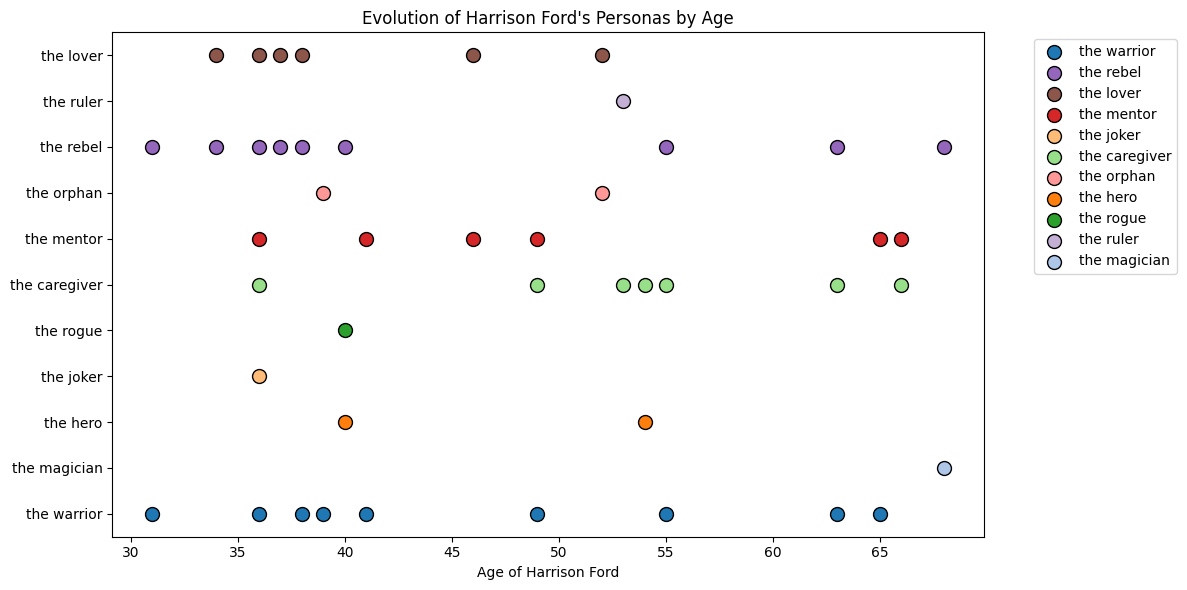

In [74]:
# Data
personas = path_example['personas_list'].item()
ages = path_example['actor_age_during_movies'].item()

# Flatten data into persona-age pairs for easier plotting
persona_age_pairs = [(age, persona) for age, persona_list in zip(ages, personas) for persona in persona_list]

# Unique personas for color mapping
unique_personas = list(set(persona for _, persona in persona_age_pairs))

# Color mapping for personas
color_map = {persona: plt.cm.tab20(i) for i, persona in enumerate(unique_personas)}

# Plotting
plt.figure(figsize=(12, 6))
for age, persona in persona_age_pairs:
    plt.scatter(age, unique_personas.index(persona), color=color_map[persona], label=persona, s=100, edgecolor="black")

# Axis setup
plt.yticks(range(len(unique_personas)), unique_personas)
plt.xlabel("Age of Harrison Ford")
plt.title("Evolution of Harrison Ford's Personas by Age")

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels in legend
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Extract information on the actors and on the characters

We firstly extracted all the information needed (actor name, character name, freebase actor id, freebase character id) from the character's metadata of the CMU dataset.

In [75]:
# select the relevant columns
df_character_useful = preprocessed_df[['Character name', 'Actor name', 'Freebase character ID', 'Freebase actor ID']]

We firstly create a util `wikidata_ID_retriever` for trying to get a wikidata ID from a freebase ID. Since all the freebase ID are not necessary present in the wikidata dataset.

In [76]:
# import the util class to convert wikidata ID to freebase ID.
from src.utils.wikidata_ID_retriever import WikidataIDRetriever

wikidataIDRetriever = WikidataIDRetriever()
# freebase ID to test
freebaseID = '/m/0c0k1'
# wikidata ID retrieve
wikiDataID = wikidataIDRetriever.retrieve_wikidata_ID(freebaseID)
wikiDataID

'Q81328'

Then we create a util `wikidata_actor_loader`to retrieve all the actors information if an actor is present on the wikidata dataset with his freebase ID defined. 

In [77]:
# extract the list of actor's freebase id and drop the duplicates
actor_freebase_id = df_character_useful['Freebase actor ID'].drop_duplicates()
print(f"Number of actors freebase IDs on CMU : {len(actor_freebase_id)}")
# import the data loader relative to the actor
from src.utils.wikidata_actor_loader import WikiDataActorLoader
actor_data_loader = WikiDataActorLoader()
# (uncomment to launch the loading and save the result in a csv)
# actor_data_loader.load_wikidata(fileName='src/data/wikidata_actors_not_clean', freebase_IDs=actor_freebase_id)
# (uncomment to clean the data retrieved previously and save them into a new csv file.)
# actor_data_loader.clean_file_data(fileName='src/data/wikidata_actors_not_clean.csv', newFileName='src/data/wikidata_actors_clean')
# load the clean version of wikidata information extracted
actor_wikidata = pd.read_csv('src/data/wikidata_actors_clean.csv')
print(f"Number of actors wikidata extracted : {actor_wikidata.shape[0]}")
actor_wikidata.head(10)


Number of actors freebase IDs on CMU : 135761
Number of actors wikidata extracted : 52806


,actor,actorLabel,birth_date,death_date,gender,imdb_id,freebase_id,nationality,occupation,spouse,children,alma_mater,award_received,wikidata_id
0,http://www.wikidata.org/entity/Q173637,Ice Cube,1969-06-15T00:00:00Z,NaN,male,nm0001084,/m/01vw26l,['United States'],"['rapper', 'songwriter', 'record producer', 't...",[],"[""O'Shea Jackson Jr.""]","['William Howard Taft Charter High School', 'W...","['star on Hollywood Walk of Fame', 'Ice Cube I...",Q173637
1,http://www.wikidata.org/entity/Q175900,Meiko Kaji,1947-03-24T00:00:00Z,NaN,female,nm0435299,/m/0576kw,['Japan'],"['musician', 'singer', 'actor']",[],[],[],"['Mainichi Film Award for Best Actress', 'Blue...",Q175900
2,http://www.wikidata.org/entity/Q181819,Fredric March,1897-08-31T00:00:00Z,1975-04-14T00:00:00Z,male,nm0545298,/m/0h1_w,['United States'],"['film actor', 'television actor', 'character ...","['Ellis Baker', 'Florence Eldridge']",[],"['Washington Park High School', 'University of...","['star on Hollywood Walk of Fame', 'Tony Award...",Q181819
3,http://www.wikidata.org/entity/Q185051,Christopher Walken,1943-03-31T00:00:00Z,NaN,male,nm0000686,/m/016fjj,['United States'],"['film actor', 'television actor', 'model', 'd...",['Georgianne Walken'],[],"['Hofstra University', ""Professional Children'...","['Sitges Grand Honorary Award', 'Theatre World...",Q185051
4,http://www.wikidata.org/entity/Q67881,Hanns Zischler,1947-06-18T00:00:00Z,NaN,male,nm0957193,/m/09k3x_,['Germany'],"['essayist', 'film actor', 'television actor',...",[],[],[],['Cross of the Order of Merit of the Federal R...,Q67881
5,http://www.wikidata.org/entity/Q68054,Gudrun Landgrebe,1950-06-20T00:00:00Z,NaN,female,nm0484727,/m/09d6hv,['Germany'],"['film actor', 'stage actor', 'actor']",[],[],['Schauspielschule Der Keller'],['Askania Award'],Q68054
6,http://www.wikidata.org/entity/Q136646,ZaSu Pitts,1894-01-03T00:00:00Z,1963-06-07T00:00:00Z,female,nm0686032,/m/01lr4p,['United States'],"['film actor', 'television actor', 'stage acto...",['Tom Gallery'],[],['Santa Cruz High School'],['star on Hollywood Walk of Fame'],Q136646
7,http://www.wikidata.org/entity/Q169963,Jason Statham,1967-07-26T00:00:00Z,NaN,male,nm0005458,/m/034hyc,['United Kingdom'],"['competitive diver', 'kickboxer', 'martial ar...",[],[],[],[],Q169963
8,http://www.wikidata.org/entity/Q186757,Seth Green,1974-02-08T00:00:00Z,NaN,male,nm0001293,/m/0gz5hs,['United States'],"['television writer', 'film actor', 'televisio...",['Clare Grant'],[],[],[],Q186757
9,http://www.wikidata.org/entity/Q188772,Willem Dafoe,1955-07-22T00:00:00Z,NaN,male,nm0000353,/m/01f7dd,['United States'],"['film actor', 'model', 'film producer', 'stag...",['Giada Colagrande'],[],"['University of Wisconsin–Milwaukee', 'Appleto...","[""Romics d'Oro"", 'Volpi Cup for Best Actor', '...",Q188772


The occupation field for each actor can be used to answer Q1, the graph below show the distributions of the actor occupations.

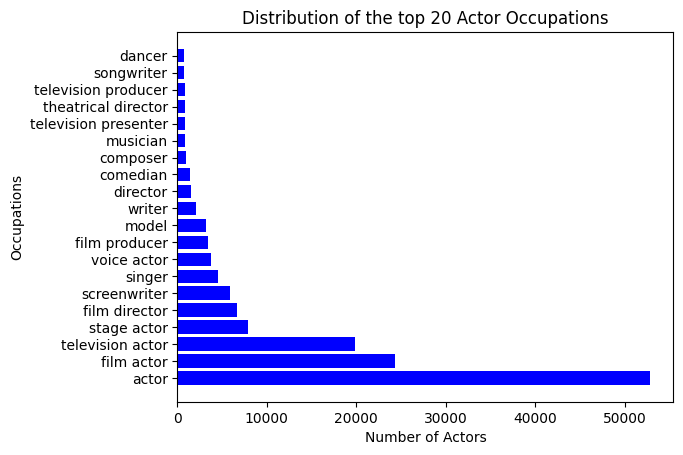

In [78]:
# convert occupation to list
actor_wikidata['occupation'] = actor_wikidata['occupation'].apply(ast.literal_eval)

# retrieve all the actor's occupation and count their occurrences
occupations_lst = [occupation for interOccupationLst in actor_wikidata['occupation'].dropna() for occupation in interOccupationLst]
occupation_count = Counter(occupations_lst)

# create a dataframe to create the graph
df_actor_occupation = pd.DataFrame(occupation_count.items(), columns=['Occupation', 'Count'])
# sort by count and only select the first 20 items for readability of the graph
df_actor_occupation = df_actor_occupation.sort_values(by='Count', ascending=False).head(20)

# construct the graph 
plt.barh(df_actor_occupation['Occupation'], df_actor_occupation['Count'], color='blue')
plt.xlabel('Number of Actors')
plt.ylabel('Occupations')
plt.title('Distribution of the top 20 Actor Occupations')
plt.show()

We also create a util `wikidata_actor_loader`to retrieve all the characters information if a character is present on the wikidata dataset with his freebase ID defined. 

In [79]:
# extract the list of character's freebase id and drop the duplicates
character_freebase_id = df_character_useful['Freebase character ID'].drop_duplicates()
print(f"Number of characters freebase IDs on CMU : {len(character_freebase_id)}")
# import the data loader relative to the character
from src.utils.wikidata_character_loader import WikiDataCharacterLoader
character_data_loader = WikiDataActorLoader()
# (uncomment to launch the loading and save the result in a csv)
# character_data_loader.load_wikidata(fileName='src/data/wikidata_characters_not_clean', freebase_IDs=character_freebase_id)
# (uncomment to clean the data retrieved previously and save them into a new csv file.)
#character_data_loader.clean_file_data(fileName='src/data/wikidata_characters_not_clean.csv', newFileName='src/data/wikidata_characters_clean')
# load the clean version of wikidata information extracted
character_wikidata = pd.read_csv('src/data/wikidata_characters_clean.csv')
print(f"Number of characters wikidata extracted : {character_wikidata.shape[0]}")
character_wikidata.head(10)

Number of characters freebase IDs on CMU : 183436
Number of characters wikidata extracted : 2873


,character,characterLabel,freebase_id,occupation,affiliation,allies,wikidata_id
0,http://www.wikidata.org/entity/Q2975734,Keyser Söze,/m/03z0qw,"['drug trafficker', 'drug lord', 'con artist']",NaN,NaN,Q2975734
1,http://www.wikidata.org/entity/Q694790,Lex Luthor,/m/04q78,"['philanthropist', 'mass murderer', 'drug traf...","['Intergang', 'Injustice League', 'LCorp', 'Se...","['Lex Luthor', 'Jr.', 'Jaxon Xavier', 'Conner ...",Q694790
2,http://www.wikidata.org/entity/Q867810,Clark Kent,/m/02362,['reporter'],"['Daily Star', 'Daily Planet']",NaN,Q867810
3,http://www.wikidata.org/entity/Q1033152,RoboCop,/m/0h3w0g,['police officer'],NaN,NaN,Q1033152
4,http://www.wikidata.org/entity/Q2260732,General Zod,/m/03jlpc,"['soldier', 'leader']","['Superman Revenge Squad', 'Suicide Squad']",['Chris Kent'],Q2260732
5,http://www.wikidata.org/entity/Q58363586,narrator,/m/0147fv,NaN,NaN,NaN,Q58363586
6,http://www.wikidata.org/entity/Q79015,Superman,/m/070vn,"['superhero', 'reporter']","['Supermen of America', 'Black Lantern Corps',...","['Jon Kent', 'Conner Kent']",Q79015
7,http://www.wikidata.org/entity/Q122018,Sinbad the Sailor,/m/01rry2,['sailor'],NaN,NaN,Q122018
8,http://www.wikidata.org/entity/Q319918,Daffy Duck,/m/0dng4,NaN,NaN,NaN,Q319918
9,http://www.wikidata.org/entity/Q845922,Lois Lane,/m/04pzy,"['journalist', 'reporter']",['Daily Planet'],"['Chris Kent', 'Jon Kent']",Q845922


We can see that not a lot of character have wikidata information, so at this step we are not sure to use the character wikidata dataset in our analysis. But to answer to Q1, we can use the occupation field of this dataset. The graph below show the occupation(role) of the character in a film.

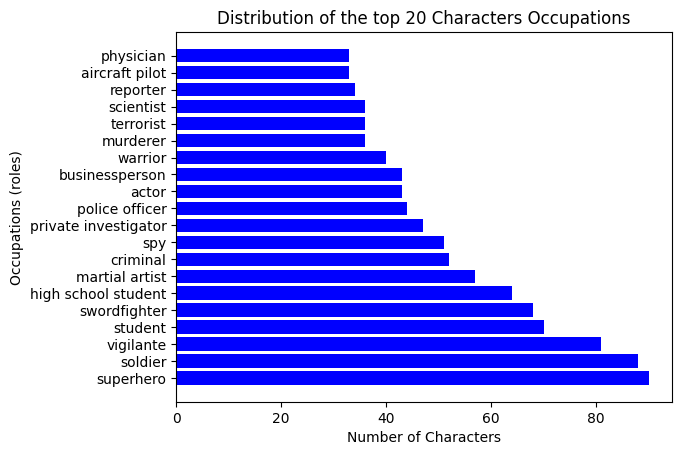

In [80]:
# convert character's occupations(role) to list
character_wikidata['occupation'] = character_wikidata['occupation'].dropna().apply(ast.literal_eval)

# retrieve all the character's occupation and count their occurrences
occupations_lst = [occupation for interOccupationLst in character_wikidata['occupation'].dropna() for occupation in interOccupationLst]
occupation_count = Counter(occupations_lst)

# create a dataframe to create the graph
df_character_occupation = pd.DataFrame(occupation_count.items(), columns=['Occupation', 'Count'])
# sort by count and only select the first 20 items for readability of the graph
df_character_occupation = df_character_occupation.sort_values(by='Count', ascending=False).head(20)

# construct the graph 
plt.barh(df_character_occupation['Occupation'], df_character_occupation['Count'], color='blue')
plt.xlabel('Number of Characters')
plt.ylabel('Occupations (roles)')
plt.title('Distribution of the top 20 Characters Occupations')
plt.show()

# Q2. How can we define a good actor's performance based on the film’s success he performed in ?

## Load the data

In [81]:
wikidata = pd.read_csv("src/data/wikidata_movie.csv")
cmu = pd.read_csv("src/data/movie.metadata.tsv", sep='\t', header=None)
imdb = pd.read_csv("src/data/title.ratings.tsv", sep='\t')

## Clean

### Wikidata

We will put the awards and nominations into lists and change the item, award and nomination from wikidata link to wikidata id.

In [82]:
wikidata_list = wikidata.copy()

wikidata_list['item'] = wikidata_list['item'].str.extract(r'(Q\d+)', expand=False)
wikidata_list['award_received'] = wikidata_list['award_received'].str.extract(r'(Q\d+)', expand=False)
wikidata_list['nominated_for'] = wikidata_list['nominated_for'].str.extract(r'(Q\d+)', expand=False)

list_columns = ["award_received", "award_receivedLabel", "nominated_for", "nominated_forLabel"]

# aggregate list columns into lists
wikidata_list = wikidata_list.groupby("imdb_id").agg({
    "item": "first",
    "itemLabel": "first",
    "freebase_id": "first",
    "budget": "first",
    **{col: lambda x: list(x.dropna().unique()) for col in list_columns}
}).reset_index()

wikidata_list.columns = ['imdb_id', 'wikidata_id', 'title', 'freebase_id', 'budget', 'award_received_id', 'award_received', 'nominated_for_id', 'nominated_for']

display(wikidata_list)

,imdb_id,wikidata_id,title,freebase_id,budget,award_received_id,award_received,nominated_for_id,nominated_for
0,co0301860,Q20001820,First Frame Entertainment,/m/0138gkng,NaN,[],[],[],[]
1,nm0704910,Q8053926,Yitzhak Rabin,/m/02x3fbz,NaN,[],[],[],[]
2,nm1016169,Q5351026,El Cimarrón,/m/02q256v,NaN,[],[],[],[]
3,nm5439868,Q16253688,Romance,/m/0wk_rx1,NaN,[],[],[],[]
4,nm5641510,Q16977718,Padre de Familia,/m/0_fp379,NaN,[],[],[],[]
...,...,...,...,...,...,...,...,...,...
121485,tt9860378,Q5317836,Dwaar,/m/0pmfdln,NaN,[],[],[],[]
121486,tt9881364,Q5517523,Gaja,/m/04g0_80,NaN,[],[],[],[]
121487,tt9890070,Q20649498,Maaya,/m/0114vlyl,NaN,[],[],[],[]
121488,tt9898504,Q7262191,Puteri Gunong Ledang,/m/027jl28,NaN,[],[],[],[]


### CMU

We will add names to columns.

In [83]:
cmu.columns = ["wiki_id", "freebase_id", "name", "release_date", "box_office", "runtime", "language", "countries", "genres"]
display(cmu)

,wiki_id,freebase_id,name,release_date,box_office,runtime,language,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


### IMDB

Update the column's name.

In [84]:
imdb.columns = ['imdb_id', 'averageRating',	'numVotes']
display(imdb)

,imdb_id,averageRating,numVotes
0,tt0000001,5.7,2100
1,tt0000002,5.6,282
2,tt0000003,6.5,2118
3,tt0000004,5.4,182
4,tt0000005,6.2,2850
...,...,...,...
1497916,tt9916730,7.0,12
1497917,tt9916766,7.1,24
1497918,tt9916778,7.2,37
1497919,tt9916840,6.9,11


### Merging the dataset

In [85]:
merge = cmu.merge(wikidata_list, on='freebase_id', how='left')
merge = merge.merge(imdb, on='imdb_id', how='left')
print(merge.columns)

Index(['wiki_id', 'freebase_id', 'name', 'release_date', 'box_office',
       'runtime', 'language', 'countries', 'genres', 'imdb_id', 'wikidata_id',
       'title', 'budget', 'award_received_id', 'award_received',
       'nominated_for_id', 'nominated_for', 'averageRating', 'numVotes'],
      dtype='object')


### The Cleaning of the dataset

We will first cast every column into their correct type.

In [86]:
merge_ctype = merge.copy()

# some dates have missing day and month so it will default them as 1st of january
merge_ctype['release_date'] = merge_ctype['release_date'].apply(lambda x: f"{x}-01-01" if len(str(x)) == 4 else x)
merge_ctype['release_date'] = pd.to_datetime(merge_ctype['release_date'], errors='coerce', format='%Y-%m-%d')

# float as int cannot have NaN values
merge_ctype['box_office'] = merge_ctype['box_office'].astype(float)

merge_ctype['runtime'] = merge_ctype['runtime'].astype(float)

merge_ctype['language'] = merge_ctype['language'].apply(lambda x: [str(v).removesuffix(' Language').removesuffix(' language') for v in ast.literal_eval(x).values()] if ast.literal_eval(x) else None)

merge_ctype['countries'] = merge_ctype['countries'].apply(lambda x: [str(v) for v in ast.literal_eval(x).values()] if ast.literal_eval(x) else None)

merge_ctype['genres'] = merge_ctype['genres'].apply(lambda x: [str(v) for v in ast.literal_eval(x).values()] if ast.literal_eval(x) else None)

# drop this column as it is the same as 'name'
merge_ctype.drop(columns=['title'], inplace=True)

merge_ctype['budget'] = merge_ctype['budget'].astype(float)

merge_ctype['award_received_id'] = merge_ctype['award_received_id'].apply(lambda x: [str(i) for i in x] if isinstance(x, list) else list())

merge_ctype['award_received'] = merge_ctype['award_received'].apply(lambda x: [str(i) for i in x] if isinstance(x, list) else list())

merge_ctype['nominated_for_id'] = merge_ctype['nominated_for_id'].apply(lambda x: [str(i) for i in x] if isinstance(x, list) else list())

merge_ctype['nominated_for'] = merge_ctype['nominated_for'].apply(lambda x: [str(i) for i in x] if isinstance(x, list) else list())

merge_ctype['averageRating'] = merge_ctype['averageRating'].astype(float)

merge_ctype['numVotes'] = merge_ctype['numVotes'].astype(float)

display(merge_ctype)

,wiki_id,freebase_id,name,release_date,box_office,runtime,language,countries,genres,imdb_id,wikidata_id,budget,award_received_id,award_received,nominated_for_id,nominated_for,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,Q261700,NaN,[],[],[],[],4.9,58894.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",tt0245916,Q16250726,NaN,[],[],[],[],6.1,77.0
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",tt0094806,Q4978832,NaN,[],[],[],[],5.6,42.0
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,Q7995657,NaN,[],[],[],[],6.1,3090.0
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German],[Germany],[Drama],tt0083949,Q869644,NaN,[],[],[Q125506406],[International Submission to the Academy Awards],5.9,647.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81859,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama],tt1816585,Q6819873,NaN,[],[],[],[],4.6,1744.0
81860,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,Q12125420,NaN,[],[],[],[],6.8,3253.0
81861,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English],[United States of America],"[Satire, Comedy]",tt0362411,Q4770308,NaN,[],[],[],[],5.9,117.0
81862,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",tt0113726,Q2663931,NaN,[],[],[],[],6.0,678.0


### Films

In [87]:
print('Number of films:', len(merge_ctype))
print('Number of NaN in Wikidata:', merge_ctype['wikidata_id'].isna().sum())

display(merge_ctype[merge_ctype['wikidata_id'].isna()])

Number of films: 81864
Number of NaN in Wikidata: 8505


,wiki_id,freebase_id,name,release_date,box_office,runtime,language,countries,genres,imdb_id,wikidata_id,budget,award_received_id,award_received,nominated_for_id,nominated_for,averageRating,numVotes
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",NaN,NaN,NaN,[],[],[],[],NaN,NaN
34,31025505,/m/0gg5xnj,El Misterioso señor Marquina,1943-01-01,NaN,NaN,[Spanish],[Mexico],"[Mystery, Drama]",NaN,NaN,NaN,[],[],[],[],NaN,NaN
39,26623942,/m/0bh9fbk,Kausthubham,2010-03-19,NaN,NaN,[Malayalam],[India],[Drama],NaN,NaN,NaN,[],[],[],[],NaN,NaN
50,21153158,/m/05c4bry,Behind The Player: John 5,2008-11-01,NaN,72.0,None,None,None,NaN,NaN,NaN,[],[],[],[],NaN,NaN
71,32104837,/m/0g4zl4c,It Came Upon the Midnight Clear,1984-12-15,NaN,99.0,[English],[United States of America],"[Family Film, Drama, Christmas movie, Televisi...",NaN,NaN,NaN,[],[],[],[],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81776,32549192,/m/0h1dc4t,Blood Feast,1972-01-01,NaN,93.0,None,[Mexico],[Horror],NaN,NaN,NaN,[],[],[],[],NaN,NaN
81781,24180469,/m/07khb1x,Angel,1966-01-01,NaN,7.0,[English],[Canada],"[Short Film, Animation]",NaN,NaN,NaN,[],[],[],[],NaN,NaN
81799,27150405,/m/0bwh_5z,Vajram,2004-01-01,NaN,NaN,[Malayalam],[India],"[Action, Drama]",NaN,NaN,NaN,[],[],[],[],NaN,NaN
81819,35056182,/m/0j62hf9,Bug Bites: An Ant's Life,1998-01-01,NaN,NaN,[English],[United States of America],"[Family Film, Animation]",NaN,NaN,NaN,[],[],[],[],NaN,NaN


As we can see many films were not fully migrated to the wikidata and some were labeled differently like 'Behind The Player: John 5' which is marked as an album in the wikidata and as an interactive music video in wikipedia.
So we will drop those that are not part of the wikidata as we will not have enough information to use them.

In [88]:
merge_ctype = merge_ctype[merge_ctype['wikidata_id'].notna()]
print('New number of films:', len(merge_ctype))

# save clean dataset (already saved)
# merge_ctype.to_pickle("src/data/movie_wikidata_cmu_imdb.pkl")

New number of films: 73359


## Analysing

### Budget and box office

Number of films: 73359
Box Office - NaN: 65032 Non-NaN: 8327 Percentage of non-NaN: 11.351027140500825 %
Budget - NaN: 70155 Non-NaN: 3204 Percentage of non-NaN: 4.367562262299105 %
Both non-NaN: 1886

Box Office Stats:
 count    8.327000e+03
mean     4.821696e+07
std      1.124112e+08
min      1.000000e+04
25%      2.117742e+06
50%      1.084878e+07
75%      4.102796e+07
max      2.782275e+09
Name: box_office, dtype: float64

Budget Stats:
 count    3.204000e+03
mean     4.373263e+07
std      3.370081e+08
min      9.200000e+00
1%       1.500000e+04
5%       1.300000e+05
10%      3.500000e+05
25%      1.700000e+06
50%      8.810000e+06
75%      3.300000e+07
max      1.200000e+10
Name: budget, dtype: float64


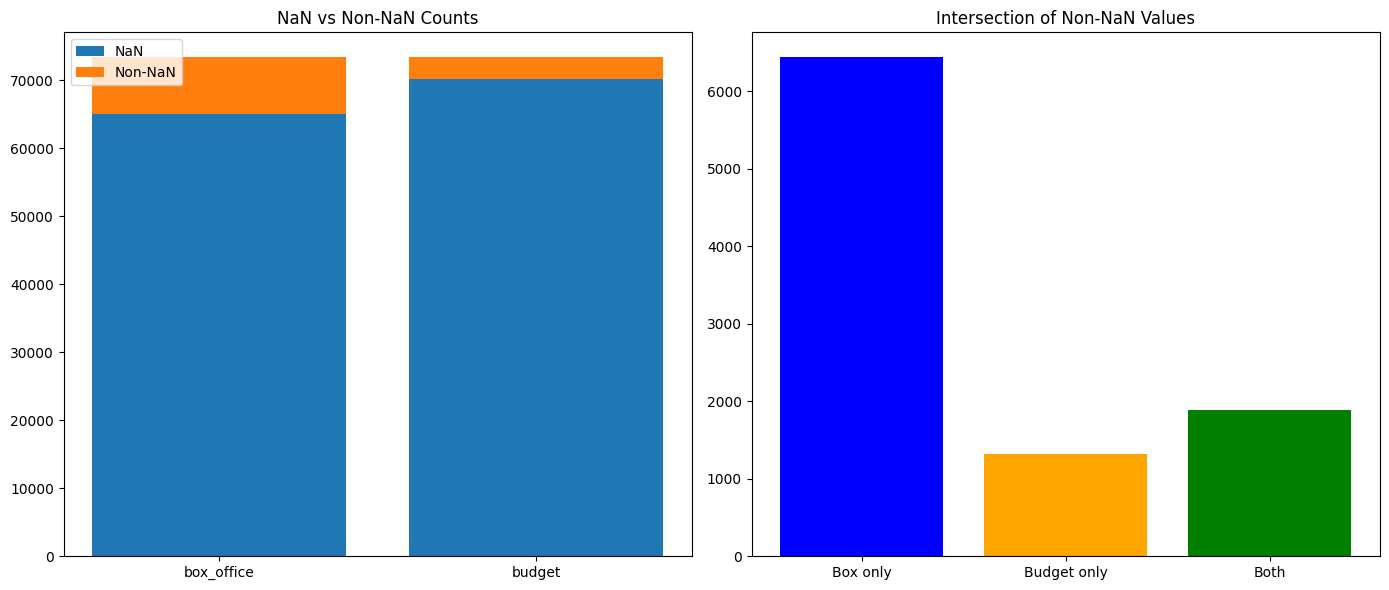

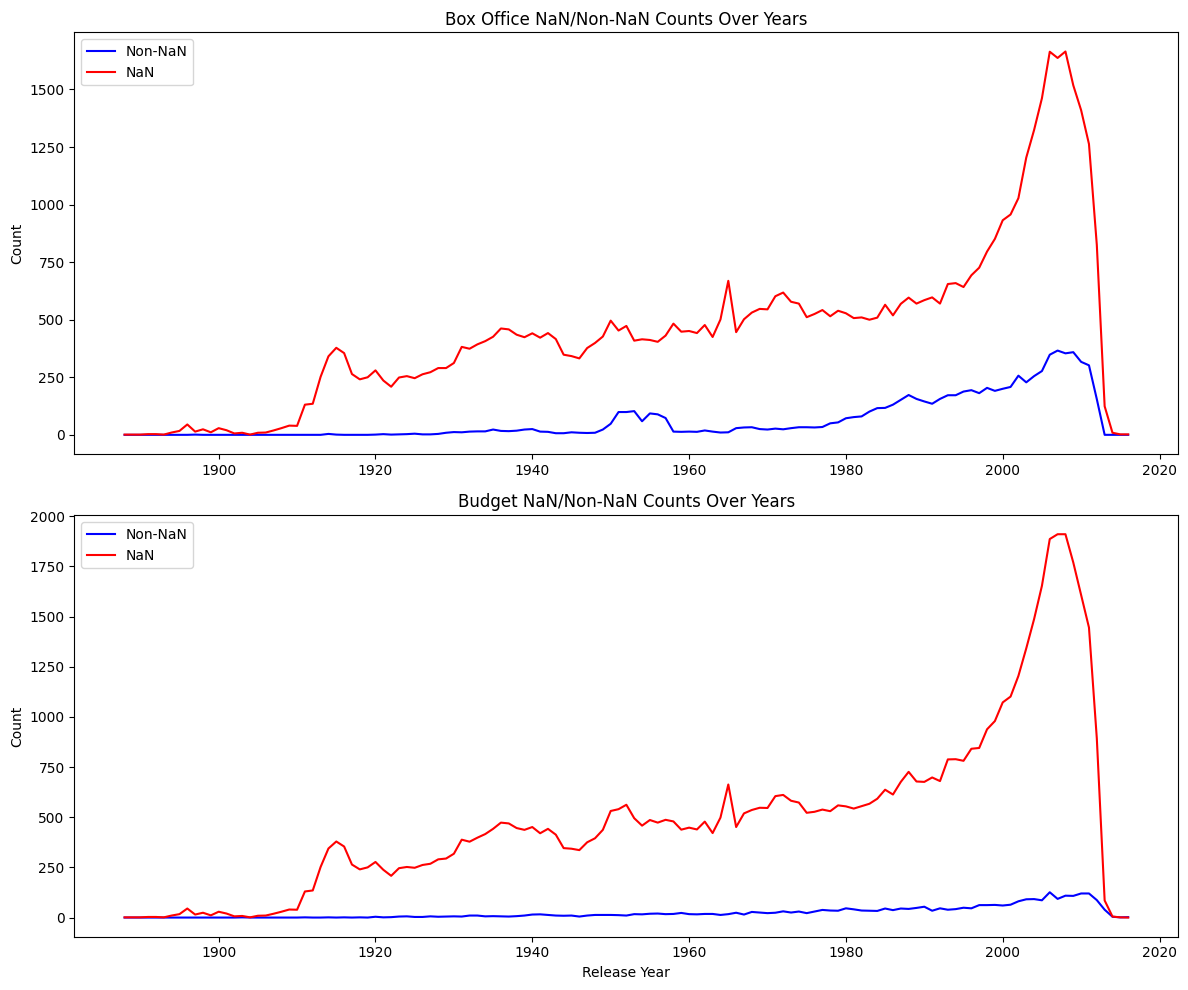

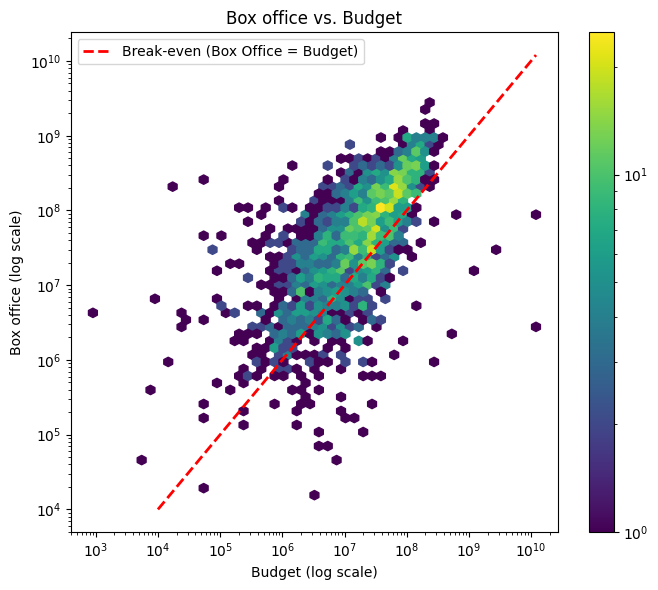

In [89]:
# Count NaN and non-NaN for each column
box_office_na = merge_ctype['box_office'].isna().sum()
box_office_non_na = merge_ctype['box_office'].notna().sum()

budget_na = merge_ctype['budget'].isna().sum()
budget_non_na = merge_ctype['budget'].notna().sum()

# Count intersection (non-NaN in both) and one-sided NaNs
box_and_budget_non_na = merge_ctype.dropna(subset=['box_office', 'budget']).shape[0]
box_only_non_na = merge_ctype['box_office'].notna().sum() - box_and_budget_non_na
budget_only_non_na = merge_ctype['budget'].notna().sum() - box_and_budget_non_na

# Describe box office and budget
box_office_stats = merge_ctype['box_office'].describe()
budget_stats = merge_ctype['budget'].describe(percentiles=[.01, .05, .1, .25, .5, .75])

# Print results
print("Number of films:", len(merge_ctype))
print("Box Office - NaN:", box_office_na, "Non-NaN:", box_office_non_na, "Percentage of non-NaN:", (box_office_non_na / len(merge_ctype)) *100, "%")
print("Budget - NaN:", budget_na, "Non-NaN:", budget_non_na, "Percentage of non-NaN:", (budget_non_na / len(merge_ctype)) *100, "%")
print("Both non-NaN:", box_and_budget_non_na)
print("\nBox Office Stats:\n", box_office_stats)
print("\nBudget Stats:\n", budget_stats)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for NaN vs non-NaN
counts = {
    "box_office": [box_office_na, box_office_non_na],
    "budget": [budget_na, budget_non_na]
}
axs[0].bar(counts.keys(), [v[0] for v in counts.values()], label="NaN")
axs[0].bar(counts.keys(), [v[1] for v in counts.values()], bottom=[v[0] for v in counts.values()], label="Non-NaN")
axs[0].set_title("NaN vs Non-NaN Counts")
axs[0].legend()

# intersection plot
intersection_counts = [box_only_non_na, budget_only_non_na, box_and_budget_non_na]
axs[1].bar(["Box only", "Budget only", "Both"], intersection_counts, color=['blue', 'orange', 'green'])
axs[1].set_title("Intersection of Non-NaN Values")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Group by year
groupedByReleaseDate = merge_ctype.copy()
groupedByReleaseDate['release_year'] = groupedByReleaseDate['release_date'].dt.year
groupedByReleaseDate = groupedByReleaseDate.groupby('release_year')

# Plot box office counts
box_office_counts = groupedByReleaseDate['box_office'].agg(['count', lambda x: x.isna().sum()]).rename(
    columns={'count': 'Non-NaN', '<lambda_0>': 'NaN'}
)
ax[0].plot(box_office_counts.index, box_office_counts['Non-NaN'], label='Non-NaN', color='blue')
ax[0].plot(box_office_counts.index, box_office_counts['NaN'], label='NaN', color='red')
ax[0].set_title('Box Office NaN/Non-NaN Counts Over Years')
ax[0].legend()
ax[0].set_ylabel('Count')

# Plot budget counts
budget_counts = groupedByReleaseDate['budget'].agg(['count', lambda x: x.isna().sum()]).rename(
    columns={'count': 'Non-NaN', '<lambda_0>': 'NaN'}
)
ax[1].plot(budget_counts.index, budget_counts['Non-NaN'], label='Non-NaN', color='blue')
ax[1].plot(budget_counts.index, budget_counts['NaN'], label='NaN', color='red')
ax[1].set_title('Budget NaN/Non-NaN Counts Over Years')
ax[1].legend()
ax[1].set_ylabel('Count')

plt.xlabel('Release Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(7, 6))

hb = axs.hexbin(merge_ctype['budget'], merge_ctype['box_office'], bins='log', gridsize=50, xscale='log', yscale='log')
fig.colorbar(hb, ax=axs)
axs.set_xlabel("Budget (log scale)")
axs.set_ylabel("Box office (log scale)")
axs.set_title("Box office vs. Budget")

lims = [max(min(merge_ctype['budget'].min(), merge_ctype['box_office'].min()), 1e4), max(merge_ctype['budget'].max(), merge_ctype['box_office'].max())]
axs.plot(lims, lims, color='red', linestyle='--', linewidth=2, label="Break-even (Box Office = Budget)")
axs.legend()

plt.tight_layout()
plt.show()


We can see that only a few films have a box office or budget. We also have some errors in budget such as 'Chico and Rita' which is defined with a budget of 9.2 euro in wikidata, but it had a budget of 200 millions based on wikipedia. So for budget, a reasonable assumption is to drop the budget in the low 1%.

We can see that most budget are between 10^6 and 10^8 and box office are between 10^6 and 10^9. We also have a majority of films that have a higher box office revenue than budget with some outliers with a big difference between budget and box office revenue.

### Average ratings and number of votes

Number of films: 73359
Ratings - NaN: 5546 Non-NaN: 67813 Percentage of non-NaN: 92.43991875570823 %
Votes - NaN: 5546 Non-NaN: 67813 Percentage of non-NaN: 92.43991875570823 %
Both non-NaN: 67813

Ratings Stats:
 count    67813.000000
mean         6.219695
std          1.143788
min          1.000000
25%          5.600000
50%          6.300000
75%          7.000000
max         10.000000
Name: averageRating, dtype: float64

Votes Stats:
 count    6.781300e+04
mean     1.178105e+04
std      6.959601e+04
min      5.000000e+00
25%      1.180000e+02
50%      5.350000e+02
75%      2.471000e+03
max      2.961164e+06
Name: numVotes, dtype: float64


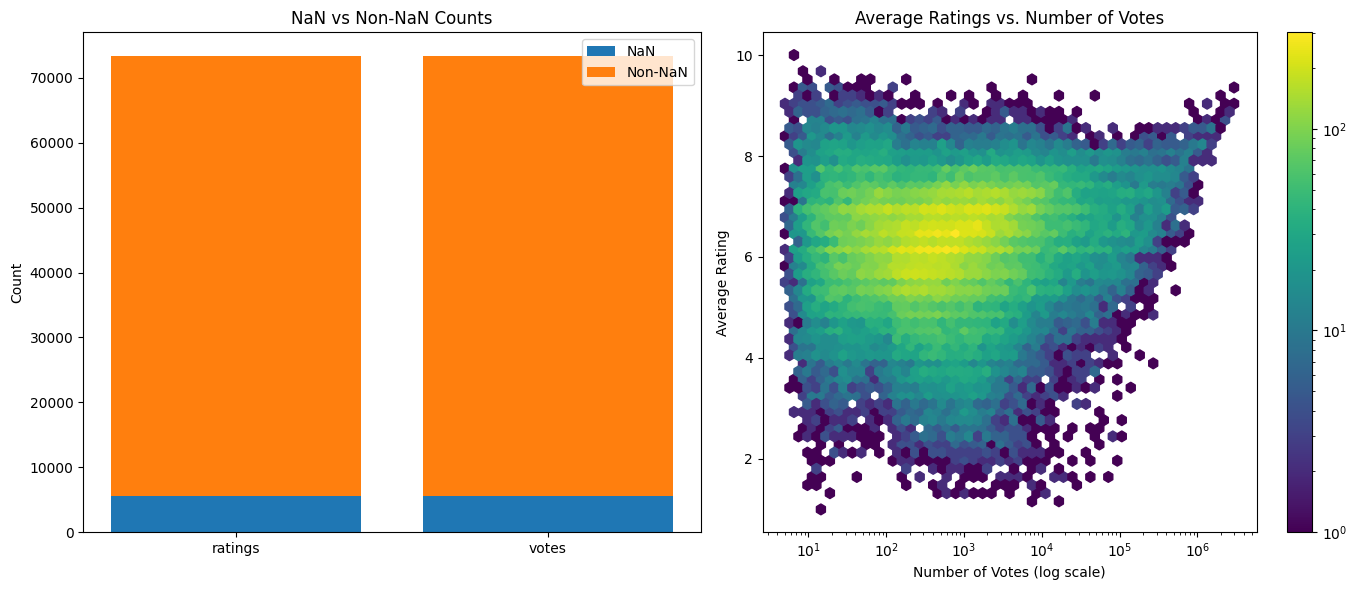

In [90]:
# Count NaN and non-NaN for each column
ratings_na = merge_ctype['averageRating'].isna().sum()
ratings_non_na = merge_ctype['averageRating'].notna().sum()

votes_na = merge_ctype['numVotes'].isna().sum()
votes_non_na = merge_ctype['numVotes'].notna().sum()

# Count intersection (non-NaN in both) and one-sided NaNs
ratings_and_votes_non_na = merge_ctype.dropna(subset=['averageRating', 'numVotes']).shape[0]
ratings_only_non_na = merge_ctype['averageRating'].notna().sum() - ratings_and_votes_non_na
votes_only_non_na = merge_ctype['numVotes'].notna().sum() - ratings_and_votes_non_na

# Describe ratings and budget
ratings_stats = merge_ctype['averageRating'].describe()
votes_stats = merge_ctype['numVotes'].describe()

# Print results
print("Number of films:", len(merge_ctype))
print("Ratings - NaN:", ratings_na, "Non-NaN:", ratings_non_na, "Percentage of non-NaN:", (ratings_non_na / len(merge_ctype)) *100, "%")
print("Votes - NaN:", votes_na, "Non-NaN:", votes_non_na, "Percentage of non-NaN:", (votes_non_na / len(merge_ctype)) *100, "%")
print("Both non-NaN:", ratings_and_votes_non_na)
print("\nRatings Stats:\n", ratings_stats)
print("\nVotes Stats:\n", votes_stats)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for NaN vs non-NaN
counts = {
    "ratings": [ratings_na, ratings_non_na],
    "votes": [votes_na, votes_non_na]
}
axs[0].bar(counts.keys(), [v[0] for v in counts.values()], label="NaN")
axs[0].bar(counts.keys(), [v[1] for v in counts.values()], bottom=[v[0] for v in counts.values()], label="Non-NaN")
axs[0].set_title("NaN vs Non-NaN Counts")
axs[0].set_ylabel('Count')
axs[0].legend()

# hex plot
hb = axs[1].hexbin(merge_ctype['numVotes'], merge_ctype['averageRating'], bins='log', gridsize=50, xscale='log')
fig.colorbar(hb, ax=axs[1])
axs[1].set_xlabel("Number of Votes (log scale)")
axs[1].set_ylabel("Average Rating")
axs[1].set_title("Average Ratings vs. Number of Votes")

plt.tight_layout()
plt.show()

Ratings might be better as there is a lot more non-NaN ratings. Also, we can see that the mean is towards 6, a bit higher than average and also that the tendency is that when after around 10^5, the average ratings are getting towards 10. Therefore, we could conclude that a large number of vote and ratings could indicate a big film success with blockbusters.

# Q3. How can we measure the impact of an award on an actor's career in the cinematic field ?

**Preprocessing the data:**
First we have three datasets that we want to merge to obtain two datasets. The first dataset is `wikidata_actors_clean`, the second is `movie_wikidata_cmu_imdb` and the third one is oscars.csv.

In [91]:
#load data
oscars = pd.read_csv('src/data/oscars.csv',  sep="	")
actors = pd.read_csv('src/data/wikidata_actors_clean.csv')
movies = pd.read_pickle('src/data/movie_wikidata_cmu_imdb.pkl')

display(oscars)
display(actors)
display(movies)

,Ceremony,Year,Class,CanonicalCategory,Category,NomId,Film,FilmId,Name,Nominees,NomineeIds,Winner,Detail,Note,Citation,MultifilmNomination
0,1,1927/28,Acting,ACTOR,ACTOR,an0051251,The Noose,tt0019217,Richard Barthelmess,Richard Barthelmess,nm0001932,NaN,Nickie Elkins,NaN,NaN,True
1,1,1927/28,Acting,ACTOR,ACTOR,an0051252,The Patent Leather Kid,tt0018253,Richard Barthelmess,Richard Barthelmess,nm0001932,NaN,The Patent Leather Kid,NaN,NaN,True
2,1,1927/28,Acting,ACTOR,ACTOR,an0051250a,The Last Command,tt0019071,Emil Jannings,Emil Jannings,nm0417837,True,General Dolgorucki [Grand Duke Sergius Alexander],NaN,NaN,True
3,1,1927/28,Acting,ACTOR,ACTOR,an0051250b,The Way of All Flesh,tt0019553,Emil Jannings,Emil Jannings,nm0417837,True,August Schilling,NaN,NaN,True
4,1,1927/28,Acting,ACTRESS,ACTRESS,an0051255,A Ship Comes In,tt0018389,Louise Dresser,Louise Dresser,nm0237571,NaN,Mrs. Pleznik,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11871,96,2023,SciTech,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,an2054602,NaN,NaN,NaN,Jon G. Belyeu,nm0069781,True,NaN,The unique and resilient design of this suite ...,To JON G. BELYEU for the design and engineerin...,NaN
11872,96,2023,SciTech,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,an2054603,NaN,NaN,NaN,"James Eggleton, Delwyn Holroyd","nm1271684,nm6153536",True,NaN,The HDE codec allows productions to leverage f...,To JAMES EGGLETON and DELWYN HOLROYD for the d...,NaN
11873,96,2023,SciTech,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,NaN,NaN,NaN,NaN,"Jeff Lait, Dan Bailey, Nicholas Avramoussis",NaN,True,NaN,Core engineering developments contributed by O...,"To JEFF LAIT, DAN BAILEY and NICHOLAS AVRAMOUS...",NaN
11874,96,2023,SciTech,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,SCIENTIFIC AND TECHNICAL AWARD (Technical Achi...,NaN,NaN,NaN,NaN,"Oliver Castle, Marcus Schoo, Keith Lackey",NaN,True,NaN,Atlas's scene description and evaluation frame...,To OLIVER CASTLE and MARCUS SCHOO for the desi...,NaN


,actor,actorLabel,birth_date,death_date,gender,imdb_id,freebase_id,nationality,occupation,spouse,children,alma_mater,award_received,wikidata_id
0,http://www.wikidata.org/entity/Q173637,Ice Cube,1969-06-15T00:00:00Z,NaN,male,nm0001084,/m/01vw26l,['United States'],"['rapper', 'songwriter', 'record producer', 't...",[],"[""O'Shea Jackson Jr.""]","['William Howard Taft Charter High School', 'W...","['star on Hollywood Walk of Fame', 'Ice Cube I...",Q173637
1,http://www.wikidata.org/entity/Q175900,Meiko Kaji,1947-03-24T00:00:00Z,NaN,female,nm0435299,/m/0576kw,['Japan'],"['musician', 'singer', 'actor']",[],[],[],"['Mainichi Film Award for Best Actress', 'Blue...",Q175900
2,http://www.wikidata.org/entity/Q181819,Fredric March,1897-08-31T00:00:00Z,1975-04-14T00:00:00Z,male,nm0545298,/m/0h1_w,['United States'],"['film actor', 'television actor', 'character ...","['Ellis Baker', 'Florence Eldridge']",[],"['Washington Park High School', 'University of...","['star on Hollywood Walk of Fame', 'Tony Award...",Q181819
3,http://www.wikidata.org/entity/Q185051,Christopher Walken,1943-03-31T00:00:00Z,NaN,male,nm0000686,/m/016fjj,['United States'],"['film actor', 'television actor', 'model', 'd...",['Georgianne Walken'],[],"['Hofstra University', ""Professional Children'...","['Sitges Grand Honorary Award', 'Theatre World...",Q185051
4,http://www.wikidata.org/entity/Q67881,Hanns Zischler,1947-06-18T00:00:00Z,NaN,male,nm0957193,/m/09k3x_,['Germany'],"['essayist', 'film actor', 'television actor',...",[],[],[],['Cross of the Order of Merit of the Federal R...,Q67881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52801,http://www.wikidata.org/entity/Q16008362,Richard Dolman,1895-11-30T00:00:00Z,1978-02-03T00:00:00Z,male,nm0231197,/m/0n58fhr,"['United Kingdom', 'United Kingdom']","['film actor', 'actor']",[],[],[],[],Q16008362
52802,http://www.wikidata.org/entity/Q16740996,Stuart Latham,1912-07-11T00:00:00Z,1993-08-31T00:00:00Z,male,nm0490117,/m/0gbyxpd,['United Kingdom'],"['television producer', 'actor']",['Barbara Lott'],[],[],[],Q16740996
52803,http://www.wikidata.org/entity/Q22676797,Bill Fiore,1940-01-01T00:00:00Z,2014-10-03T00:00:00Z,male,nm0278446,/m/0gcd6yb,['United States'],['actor'],[],[],[],[],Q22676797
52804,http://www.wikidata.org/entity/Q27186548,Tilly Scott Pedersen,1975-01-01T00:00:00Z,NaN,female,nm1690409,/m/0gcx9r7,['Denmark'],"['model', 'actor']",[],[],[],[],Q27186548


,wiki_id,freebase_id,name,release_date,box_office,runtime,language,countries,genres,imdb_id,wikidata_id,budget,award_received_id,award_received,nominated_for_id,nominated_for,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,Q261700,NaN,[],[],[],[],4.9,58894.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",tt0245916,Q16250726,NaN,[],[],[],[],6.1,77.0
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",tt0094806,Q4978832,NaN,[],[],[],[],5.6,42.0
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,Q7995657,NaN,[],[],[],[],6.1,3090.0
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German],[Germany],[Drama],tt0083949,Q869644,NaN,[],[],[Q125506406],[International Submission to the Academy Awards],5.9,647.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81859,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama],tt1816585,Q6819873,NaN,[],[],[],[],4.6,1744.0
81860,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,Q12125420,NaN,[],[],[],[],6.8,3253.0
81861,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English],[United States of America],"[Satire, Comedy]",tt0362411,Q4770308,NaN,[],[],[],[],5.9,117.0
81862,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",tt0113726,Q2663931,NaN,[],[],[],[],6.0,678.0


**Oscars dataset:** We can see that the columns `Citation, Detail, Note, Name, Category` are not relevant to show the success of an actor or a movie either because they are redundant or doesn't give hint about success. Then we will split this dataset into two datasets. One concerning the actors and the other one concerning other categories. For the dataset that focuses on actors we don't need the FilmId anymore since we will use the NomID to link it to the wikidata actors dataset. For the dataset that focuses on movie we will also drop the nominees since it will not give a hint on how actors plays well but more on the impact of the movie on them.
**Actors dataset:** The columns `occupation, nationality, spouse, children, alma_mater` are not relevant for this question.
**Movie dataset:** The columns `budget, item, countries, language, runtime, box_office, wiki_id and freebase_id` are not relevant for this question.

In [92]:
def extract_first_four_digits(date):
    date = str(date)
    if date[:4].isdigit():
        return date[:4]
    return None

In [93]:
# remove columns that are not needed
oscars = oscars.drop(columns=['Name','Citation','Detail','Note','Name','Category','NomId'])
actors = actors.drop(columns=['occupation','nationality','spouse','children','alma_mater','freebase_id','wikidata_id'])
movies = movies.drop(columns=['budget','countries','language','runtime','box_office','wiki_id','freebase_id', 'averageRating', 'numVotes'])

# extract the first year of the year of oscars
oscars['Year'] = oscars['Year'].apply(extract_first_four_digits)

# taking only the oscars received by the actors
oscarsActors = oscars[(oscars['Class'] == 'Acting')]
oscarsActors = oscarsActors.dropna(subset=['NomineeIds'])
oscarsActors = oscarsActors.drop(columns=['FilmId'])
oscarsActors.rename(columns={'NomineeIds': 'imdb_id'}, inplace=True)

# taking the other oscars (not received by the actors)
oscarsMovies = oscars[(oscars['Class'] != 'Acting')]
oscarsMovies = oscarsMovies.dropna(subset=['FilmId'])
oscarsMovies = oscarsMovies.drop(columns=['NomineeIds','Nominees'])

oscarsMovies.rename(columns={'FilmId': 'imdb_id'}, inplace=True)

display(oscarsActors)
display(oscarsMovies)


,Ceremony,Year,Class,CanonicalCategory,Film,Nominees,imdb_id,Winner,MultifilmNomination
0,1,1927,Acting,ACTOR,The Noose,Richard Barthelmess,nm0001932,NaN,True
1,1,1927,Acting,ACTOR,The Patent Leather Kid,Richard Barthelmess,nm0001932,NaN,True
2,1,1927,Acting,ACTOR,The Last Command,Emil Jannings,nm0417837,True,True
3,1,1927,Acting,ACTOR,The Way of All Flesh,Emil Jannings,nm0417837,True,True
4,1,1927,Acting,ACTRESS,A Ship Comes In,Louise Dresser,nm0237571,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11751,96,2023,Acting,ACTRESS IN A SUPPORTING ROLE,Oppenheimer,Emily Blunt,nm1289434,NaN,NaN
11752,96,2023,Acting,ACTRESS IN A SUPPORTING ROLE,The Color Purple,Danielle Brooks,nm5335029,NaN,NaN
11753,96,2023,Acting,ACTRESS IN A SUPPORTING ROLE,Barbie,America Ferrera,nm1065229,NaN,NaN
11754,96,2023,Acting,ACTRESS IN A SUPPORTING ROLE,Nyad,Jodie Foster,nm0000149,NaN,NaN


,Ceremony,Year,Class,CanonicalCategory,Film,imdb_id,Winner,MultifilmNomination
9,1,1927,Production,ART DIRECTION,Sunrise,tt0018455,NaN,NaN
10,1,1927,Production,ART DIRECTION,The Dove,tt0017822,True,True
11,1,1927,Production,ART DIRECTION,Tempest,tt0019451,True,True
12,1,1927,Production,ART DIRECTION,7th Heaven,tt0018379,NaN,NaN
13,1,1927,Production,CINEMATOGRAPHY,The Devil Dancer,tt0017806,NaN,True
...,...,...,...,...,...,...,...,...
11851,96,2023,Writing,WRITING (Original Screenplay),Anatomy of a Fall,tt17009710,True,NaN
11852,96,2023,Writing,WRITING (Original Screenplay),The Holdovers,tt14849194,NaN,NaN
11853,96,2023,Writing,WRITING (Original Screenplay),Maestro,tt5535276,NaN,NaN
11854,96,2023,Writing,WRITING (Original Screenplay),May December,tt13651794,NaN,NaN


Since the columns of `award_received` in both movies and actors wikidata have not the same weight in terms of popularity, it's not comparable to oscars that is the reference in the movie industry. We finally decided to not drop it but not make it as important in our analysis. We keep the column, but we will not analyse them.

In [94]:
actorsAwards = actors[actors['award_received'] != '[]']
actorsAwards = actorsAwards.dropna(subset=['award_received'])
actorsAwards = actorsAwards[['imdb_id','actorLabel','award_received']]

moviesAwards = movies[movies['award_received'] != '[]']
moviesAwards = moviesAwards.dropna(subset=['award_received'])
moviesAwards = moviesAwards[['imdb_id','name','award_received']]

movies = movies.drop(columns = ['nominated_for','award_received','nominated_for','award_received'])	
actors = actors.drop(columns = 'award_received')

display(actorsAwards)
display(moviesAwards)

,imdb_id,actorLabel,award_received
0,nm0001084,Ice Cube,"['star on Hollywood Walk of Fame', 'Ice Cube I..."
1,nm0435299,Meiko Kaji,"['Mainichi Film Award for Best Actress', 'Blue..."
2,nm0545298,Fredric March,"['star on Hollywood Walk of Fame', 'Tony Award..."
3,nm0000686,Christopher Walken,"['Sitges Grand Honorary Award', 'Theatre World..."
4,nm0957193,Hanns Zischler,['Cross of the Order of Merit of the Federal R...
...,...,...,...
52775,nm0059106,Charles Barton,['Academy Award for Best Assistant Director']
52778,nm0309260,Azat Gasparyan,"['honorary citizen of Yerevan', 'Khorenatsi me..."
52779,nm0644489,Nerses Hovhannisyan,['Honored Art Worker of the Armenian SSR']
52785,nm0788698,Levon Sharafyan,['Honored Artist of the Armenian SSR']


,imdb_id,name,award_received
0,tt0228333,Ghosts of Mars,[]
1,tt0245916,Getting Away with Murder: The JonBenét Ramsey ...,[]
2,tt0094806,Brun bitter,[]
3,tt0094320,White Of The Eye,[]
4,tt0083949,A Woman in Flames,[]
...,...,...,...
81859,tt1816585,Mermaids: The Body Found,[]
81860,tt1606259,Knuckle,[]
81861,tt0362411,Another Nice Mess,[]
81862,tt0113726,The Super Dimension Fortress Macross II: Lover...,[]


Now we want to merge the two datasets about movies and the two datasets about actors.

In [95]:

oscarsActorsmerged = actors.merge(oscarsActors, on='imdb_id', how='left')
oscarsMoviesmerged = movies.merge(oscarsMovies, on='imdb_id', how='left')

# Winner and MultifilmNomination are better in boolean format.
oscarsMoviesmerged['Winner'] = oscarsMoviesmerged['Winner'].replace('True', True)
oscarsMoviesmerged['Winner'] = oscarsMoviesmerged['Winner'].fillna(False)
oscarsMoviesmerged['MultifilmNomination'] = oscarsMoviesmerged['MultifilmNomination'].replace('True', True)
oscarsMoviesmerged['MultifilmNomination'] = oscarsMoviesmerged['MultifilmNomination'].fillna(False)

oscarsActorsmerged['Winner'] = oscarsActorsmerged['Winner'].replace('True', True)
oscarsActorsmerged['Winner'] = oscarsActorsmerged['Winner'].fillna(False)
oscarsActorsmerged['MultifilmNomination'] = oscarsActorsmerged['MultifilmNomination'].replace('True', True)
oscarsActorsmerged['MultifilmNomination'] = oscarsActorsmerged['MultifilmNomination'].fillna(False)

# We can see that the film is the same as name or Nan, Nominees can be dropped.
display(oscarsMoviesmerged)
display(oscarsActorsmerged)

/tmp/ipykernel_51558/3104090543.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  oscarsMoviesmerged['Winner'] = oscarsMoviesmerged['Winner'].fillna(False)
/tmp/ipykernel_51558/3104090543.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  oscarsMoviesmerged['MultifilmNomination'] = oscarsMoviesmerged['MultifilmNomination'].fillna(False)
/tmp/ipykernel_51558/3104090543.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

,name,release_date,genres,imdb_id,wikidata_id,award_received_id,nominated_for_id,Ceremony,Year,Class,CanonicalCategory,Film,Winner,MultifilmNomination
0,Ghosts of Mars,2001-08-24,"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,Q261700,[],[],NaN,NaN,NaN,NaN,NaN,False,False
1,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,"[Mystery, Biographical film, Drama, Crime Drama]",tt0245916,Q16250726,[],[],NaN,NaN,NaN,NaN,NaN,False,False
2,Brun bitter,1988-01-01,"[Crime Fiction, Drama]",tt0094806,Q4978832,[],[],NaN,NaN,NaN,NaN,NaN,False,False
3,White Of The Eye,1987-01-01,"[Thriller, Erotic thriller, Psychological thri...",tt0094320,Q7995657,[],[],NaN,NaN,NaN,NaN,NaN,False,False
4,A Woman in Flames,1983-01-01,[Drama],tt0083949,Q869644,[],[Q125506406],NaN,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76806,Mermaids: The Body Found,2011-03-19,[Drama],tt1816585,Q6819873,[],[],NaN,NaN,NaN,NaN,NaN,False,False
76807,Knuckle,2011-01-21,"[Biographical film, Drama, Documentary]",tt1606259,Q12125420,[],[],NaN,NaN,NaN,NaN,NaN,False,False
76808,Another Nice Mess,1972-09-22,"[Satire, Comedy]",tt0362411,Q4770308,[],[],NaN,NaN,NaN,NaN,NaN,False,False
76809,The Super Dimension Fortress Macross II: Lover...,1992-05-21,"[Science Fiction, Japanese Movies, Adventure, ...",tt0113726,Q2663931,[],[],NaN,NaN,NaN,NaN,NaN,False,False


,actor,actorLabel,birth_date,death_date,gender,imdb_id,Ceremony,Year,Class,CanonicalCategory,Film,Nominees,Winner,MultifilmNomination
0,http://www.wikidata.org/entity/Q173637,Ice Cube,1969-06-15T00:00:00Z,NaN,male,nm0001084,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,http://www.wikidata.org/entity/Q175900,Meiko Kaji,1947-03-24T00:00:00Z,NaN,female,nm0435299,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,http://www.wikidata.org/entity/Q181819,Fredric March,1897-08-31T00:00:00Z,1975-04-14T00:00:00Z,male,nm0545298,4.0,1930,Acting,ACTOR,The Royal Family of Broadway,Fredric March,False,False
3,http://www.wikidata.org/entity/Q181819,Fredric March,1897-08-31T00:00:00Z,1975-04-14T00:00:00Z,male,nm0545298,5.0,1931,Acting,ACTOR,Dr. Jekyll and Mr. Hyde,Fredric March,True,False
4,http://www.wikidata.org/entity/Q181819,Fredric March,1897-08-31T00:00:00Z,1975-04-14T00:00:00Z,male,nm0545298,10.0,1937,Acting,ACTOR,A Star Is Born,Fredric March,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53508,http://www.wikidata.org/entity/Q16008362,Richard Dolman,1895-11-30T00:00:00Z,1978-02-03T00:00:00Z,male,nm0231197,NaN,NaN,NaN,NaN,NaN,NaN,False,False
53509,http://www.wikidata.org/entity/Q16740996,Stuart Latham,1912-07-11T00:00:00Z,1993-08-31T00:00:00Z,male,nm0490117,NaN,NaN,NaN,NaN,NaN,NaN,False,False
53510,http://www.wikidata.org/entity/Q22676797,Bill Fiore,1940-01-01T00:00:00Z,2014-10-03T00:00:00Z,male,nm0278446,NaN,NaN,NaN,NaN,NaN,NaN,False,False
53511,http://www.wikidata.org/entity/Q27186548,Tilly Scott Pedersen,1975-01-01T00:00:00Z,NaN,female,nm1690409,NaN,NaN,NaN,NaN,NaN,NaN,False,False


We see that some columns are the same and the release date are not relevant since they are not sanitized.

In [96]:
oscarsActorsmerged = oscarsActorsmerged.drop(columns=['Film','actor','Nominees'])
oscarsActorsmerged = oscarsActorsmerged.rename(columns={'actorLabel': 'Actor'})
oscarsMoviesmerged = oscarsMoviesmerged.drop(columns=['name'])

In [97]:

display(oscarsActorsmerged)
oscarsMoviesmerged['release_date'] = oscarsMoviesmerged['release_date'].apply(extract_first_four_digits)
display(oscarsMoviesmerged)

,Actor,birth_date,death_date,gender,imdb_id,Ceremony,Year,Class,CanonicalCategory,Winner,MultifilmNomination
0,Ice Cube,1969-06-15T00:00:00Z,NaN,male,nm0001084,NaN,NaN,NaN,NaN,False,False
1,Meiko Kaji,1947-03-24T00:00:00Z,NaN,female,nm0435299,NaN,NaN,NaN,NaN,False,False
2,Fredric March,1897-08-31T00:00:00Z,1975-04-14T00:00:00Z,male,nm0545298,4.0,1930,Acting,ACTOR,False,False
3,Fredric March,1897-08-31T00:00:00Z,1975-04-14T00:00:00Z,male,nm0545298,5.0,1931,Acting,ACTOR,True,False
4,Fredric March,1897-08-31T00:00:00Z,1975-04-14T00:00:00Z,male,nm0545298,10.0,1937,Acting,ACTOR,False,False
...,...,...,...,...,...,...,...,...,...,...,...
53508,Richard Dolman,1895-11-30T00:00:00Z,1978-02-03T00:00:00Z,male,nm0231197,NaN,NaN,NaN,NaN,False,False
53509,Stuart Latham,1912-07-11T00:00:00Z,1993-08-31T00:00:00Z,male,nm0490117,NaN,NaN,NaN,NaN,False,False
53510,Bill Fiore,1940-01-01T00:00:00Z,2014-10-03T00:00:00Z,male,nm0278446,NaN,NaN,NaN,NaN,False,False
53511,Tilly Scott Pedersen,1975-01-01T00:00:00Z,NaN,female,nm1690409,NaN,NaN,NaN,NaN,False,False


,release_date,genres,imdb_id,wikidata_id,award_received_id,nominated_for_id,Ceremony,Year,Class,CanonicalCategory,Film,Winner,MultifilmNomination
0,2001,"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,Q261700,[],[],NaN,NaN,NaN,NaN,NaN,False,False
1,2000,"[Mystery, Biographical film, Drama, Crime Drama]",tt0245916,Q16250726,[],[],NaN,NaN,NaN,NaN,NaN,False,False
2,1988,"[Crime Fiction, Drama]",tt0094806,Q4978832,[],[],NaN,NaN,NaN,NaN,NaN,False,False
3,1987,"[Thriller, Erotic thriller, Psychological thri...",tt0094320,Q7995657,[],[],NaN,NaN,NaN,NaN,NaN,False,False
4,1983,[Drama],tt0083949,Q869644,[],[Q125506406],NaN,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76806,2011,[Drama],tt1816585,Q6819873,[],[],NaN,NaN,NaN,NaN,NaN,False,False
76807,2011,"[Biographical film, Drama, Documentary]",tt1606259,Q12125420,[],[],NaN,NaN,NaN,NaN,NaN,False,False
76808,1972,"[Satire, Comedy]",tt0362411,Q4770308,[],[],NaN,NaN,NaN,NaN,NaN,False,False
76809,1992,"[Science Fiction, Japanese Movies, Adventure, ...",tt0113726,Q2663931,[],[],NaN,NaN,NaN,NaN,NaN,False,False


Now we can have some visualisations on the datasets. First, we can show how the average of the movies and actors receiving an oscar per years changed across the years (if there is any changes)

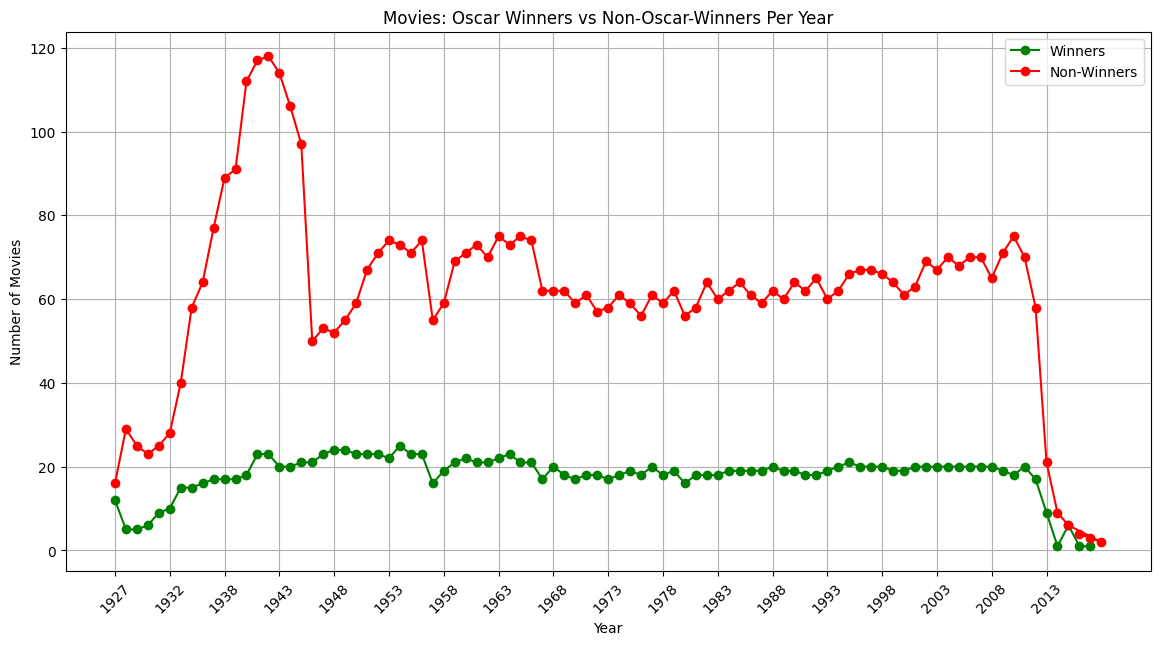

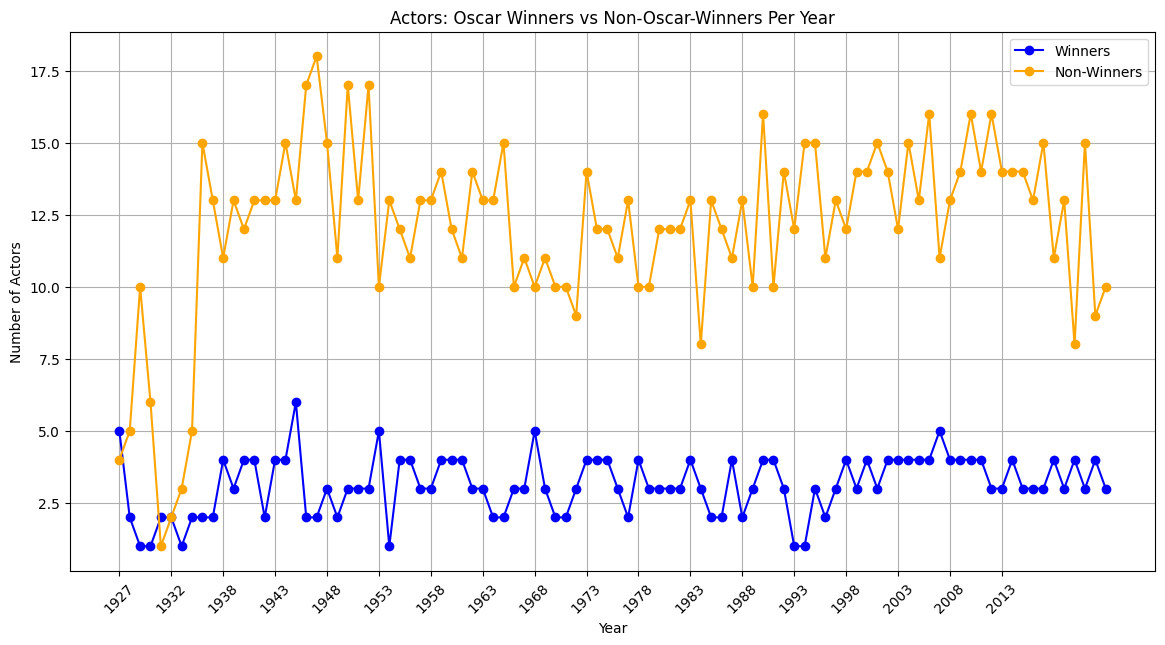

In [98]:
# Movies: Winners VS Non-Winners
movies_winners = oscarsMoviesmerged[oscarsMoviesmerged['Winner'] == True].groupby('Year').size()
movies_non_winners = oscarsMoviesmerged[oscarsMoviesmerged['Winner'] == False].groupby('Year').size()

plt.figure(figsize=(14, 7))
plt.plot(movies_winners.index, movies_winners.values, marker='o', label='Winners', color='green')
plt.plot(movies_non_winners.index, movies_non_winners.values, marker='o', label='Non-Winners', color='red')
plt.title('Movies: Oscar Winners vs Non-Oscar-Winners Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(movies_winners.index[::5], rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Actors: Winners VS Non-Winners
actors_winners = oscarsActorsmerged[oscarsActorsmerged['Winner'] == True].groupby('Year').size()
actors_non_winners = oscarsActorsmerged[oscarsActorsmerged['Winner'] == False].groupby('Year').size()

plt.figure(figsize=(14, 7))
plt.plot(actors_winners.index, actors_winners.values, marker='o', label='Winners', color='blue')
plt.plot(actors_non_winners.index, actors_non_winners.values, marker='o', label='Non-Winners', color='orange')
plt.title('Actors: Oscar Winners vs Non-Oscar-Winners Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Actors')
plt.xticks(movies_winners.index[::5], rotation=45)
plt.grid(True)
plt.legend()
plt.show()


We can see that approximately 1/3 of the actors have obtained at least one award each year. So this proves that it can be used to evaluate the impact of a given actor on a given year in the cinematographic field. This is similar for the movie's oscars.

## Q4. Does the academic and environmental background of an actor have an impact on his career success ?

### Family environment

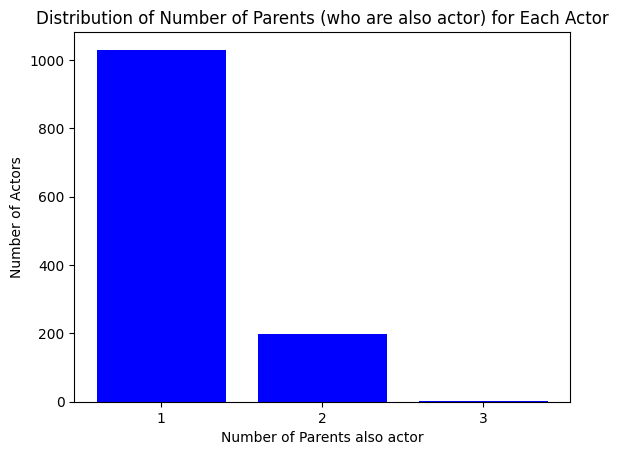

In [99]:
# transform the string of the columns of children and spouses into array.
actor_wikidata['spouse'] = actor_wikidata['spouse'].apply(ast.literal_eval)
actor_wikidata['children'] = actor_wikidata['children'].apply(ast.literal_eval)

# construct the object to retrieve the parent list of each actor.
from src.utils.retrieve_parents_from_children import ParentsFromChildrenRetriever
parentRetriever = ParentsFromChildrenRetriever(actor_wikidata=actor_wikidata)

# for each actor, retrieve the list of parents (who are also actor)
actor_wikidata['parents'] = actor_wikidata['actorLabel'].apply(parentRetriever.find_parents_for_child_actor_name)

# Visualize the results

# calculate the number of parent (who are also actor) for each actor 
actor_wikidata['number_actor_parents'] = actor_wikidata['parents'].apply(len)
number_of_parents = actor_wikidata['number_actor_parents'].value_counts().sort_index()
# only take into account the actor with at least one parent
number_of_parents = number_of_parents[number_of_parents.index > 0]

plt.bar(number_of_parents.index, number_of_parents.values, color='blue')
plt.title('Distribution of Number of Parents (who are also actor) for Each Actor')
plt.xlabel('Number of Parents also actor')
plt.ylabel('Number of Actors')
plt.xticks([1,2,3])
plt.show()


We can observe that a significant number of actors have one (or occasionally two) parents working in the cinematographic field. By using the results of Q2 and Q3, we aim to determine whether having a parent in the cinematographic field, particularly one with a successful career, might influence an actor's own career success.

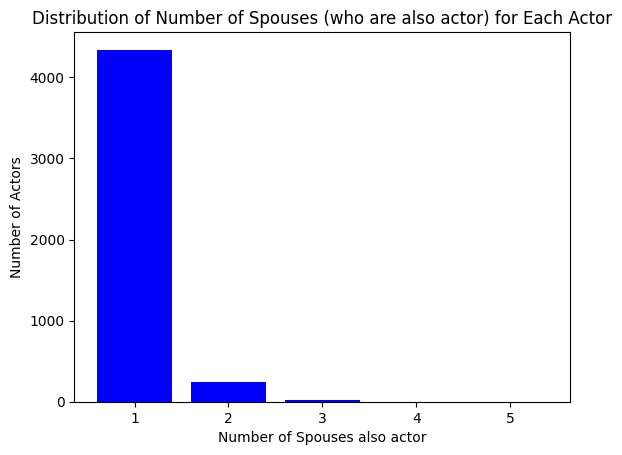

In [100]:
# calculate for each actor the number of spouses which is also an actor
actor_wikidata['number_spouse_also_actor'] = actor_wikidata['spouse'].apply(lambda spouseLst: sum(1 for elem in spouseLst if elem in actor_wikidata['actorLabel'].values))

# visualize the results
number_of_spouses = actor_wikidata['number_spouse_also_actor'].value_counts().sort_index()
# only take into account the actor with at one spouse as actor
number_of_spouses = number_of_spouses[number_of_spouses.index > 0]

plt.bar(number_of_spouses.index, number_of_spouses.values, color='blue')
plt.title('Distribution of Number of Spouses (who are also actor) for Each Actor')
plt.xlabel('Number of Spouses also actor')
plt.ylabel('Number of Actors')
plt.xticks([1,2,3,4,5])
plt.show()


We can observe that a significant number of actors have spouses working in the cinematographic field. By comparing the results of Q2 and Q3, we will aim to determine whether having a spouse in the cinematographic field, particularly one with a successful career, might also influence an actor's own career success.

### Academic background

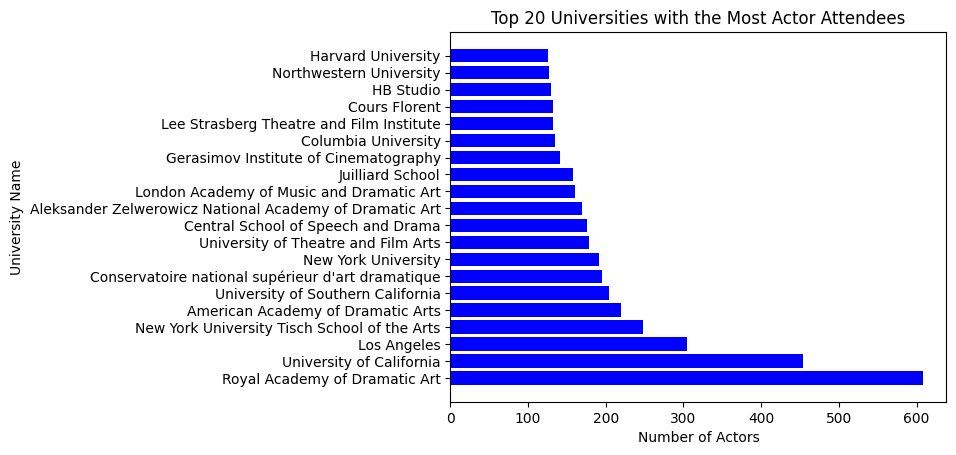

In [101]:
# flatten the list of all universities present on each actor row
universitiesLst = [university for actorUniversityLst in actor_wikidata['alma_mater'].apply(ast.literal_eval) for university in set(actorUniversityLst)] # make each university unique for each actor

# count the occurrence of each university
universityCount = Counter(universitiesLst)

# visualize the results
df_university_count = pd.DataFrame(universityCount.items(), columns=['university_name', 'number_of_actors'])
# sort the results and select only the top 20
df_university_count = df_university_count.sort_values(by=['number_of_actors'], ascending=False).head(20)

plt.barh(df_university_count['university_name'], df_university_count['number_of_actors'], color='blue')
plt.xlabel('Number of Actors')
plt.ylabel('University Name')
plt.title('Top 20 Universities with the Most Actor Attendees')
plt.show()


We can observe that many actors have attended university. By linking this with the results of Q2 and Q3, we will be able to determine if a significant number of successful actors have attended the same university and, finally, whether a particular university is known for producing successful actors.

### Nationality


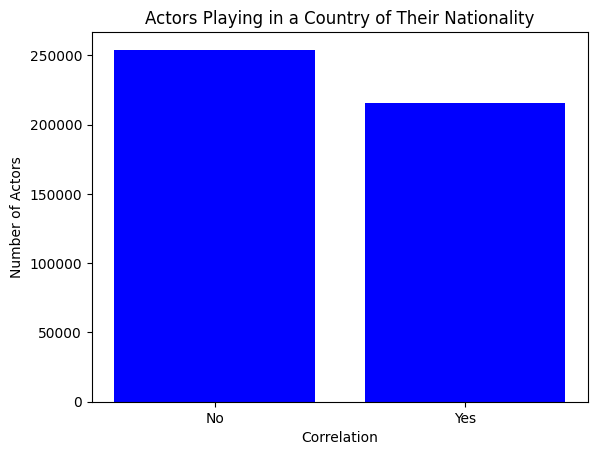

In [102]:
# combine the actor's wikidata with the CMU dataframe.
join_actor_wikidata_CMU = joined_df.merge(actor_wikidata, left_on='Freebase actor ID', right_on='freebase_id', how='left')
# convert nationality and movie country string to list
join_actor_wikidata_CMU['nationality'] = join_actor_wikidata_CMU['nationality'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
 # add a field in the dataframe to know if the actor has currently played in a country of his nationality
join_actor_wikidata_CMU['correlation production country nationality'] = join_actor_wikidata_CMU.apply(
    lambda x: len(set(x['nationality']).intersection(x['Movie countries'])) >= 1, axis=1)

# Count occurrences of True and False in the correlation
correlation_counts = join_actor_wikidata_CMU['correlation production country nationality'].value_counts()

# visualize the results
plt.bar(correlation_counts.index.astype(str), correlation_counts.values, color=['blue'])
plt.title("Actors Playing in a Country of Their Nationality")
plt.xlabel("Correlation")
plt.ylabel("Number of Actors")
plt.xticks([0, 1], ['No', 'Yes']) 
plt.show()

If approximately 40% of actors perform in their own nationality's country, it would be interesting to investigate the differences between actors who perform in their nationality's country versus those who do not. Additionally, for the actors who do not perform in their home country, it would be interesting to identify which countries they perform in most frequently. Furthermore, it will be important to establish the links between these factors (Q2 and Q3) to understand whether an actor has more success performing in their own country (local success) or internationally (global success).